# Mod 5 Project - Using Machine Learning to Predict Coronavirus

This project uses daily updated coronavirus data from John Hopkins Hospital

In [1]:
# import all neccessary libraries
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import numpy as np
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import itertools

# ignore all harmless waring to keep the notebook clean
warnings.filterwarnings('ignore')

# keep the plot inline in notebookb
%matplotlib inline

In [2]:
# load data
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
df_confirmed = pd.read_csv(url + 'time_series_19-covid-Confirmed.csv')
df_deaths = pd.read_csv(url + 'time_series_19-covid-Deaths.csv')
df_recovered = pd.read_csv(url + 'time_series_19-covid-Recovered.csv')

In [3]:
df_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,47,48,50,50,50,53,59,70,75,82
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,360,420,461,502,511,581,639,639,701,773
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,117,130,138,150,150,160,178,178,200,212
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,50,83,93,99,117,129,149,149,197,238


In [4]:
df_deaths.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,NaN,Japan,36.0000,138.0000,0,0,0,0,0,0,...,6,6,6,6,10,10,15,16,19,22
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df_recovered.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,2,2,...,31,31,31,31,31,33,34,34,35,35
1,NaN,Japan,36.0000,138.0000,0,0,0,0,1,1,...,43,46,76,76,76,101,118,118,118,118
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,...,78,78,78,78,78,78,96,96,97,105
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,...,22,22,23,24,24,24,26,26,26,35


In [6]:
# count the null columns
null_columns = df_confirmed.columns[df_confirmed.isnull().any()]
df_confirmed[null_columns].isnull().sum().head()

Province/State    135
dtype: int64

In [7]:
def melt_data(df):
    """
    melt data of one zip code from wide format to long format
    """
    
    melted = pd.melt(df, id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    #melted = melted.dropna(subset=['value'])
    
    return melted.groupby('time').aggregate({'value':'mean'})

In [8]:
def melt_df(df):
    """
    Loop through all zipcodes to melt data of each zipcode.
    Then, merge all melted data back together
    """
    
    merged = []
    for country in df['Country/Region']:
        melted = melt_data(df.loc[df['Country/Region'] == country])
        row = df.loc[df['Country/Region'] == country].iloc[:,:4]
        rows = pd.concat([row]*len(melted), ignore_index=True)
        merge = pd.concat([rows, melted.reset_index()], axis= 1)
        merged.append(merge)
    melted_df = pd.concat(merged)
    return melted_df

In [9]:
df = melt_df(df_confirmed)

In [10]:
df.head()

,Province/State,Country/Region,Lat,Long,time,value
0,NaN,Thailand,15.0,101.0,2020-01-22,2.0
1,NaN,Thailand,15.0,101.0,2020-01-23,3.0
2,NaN,Thailand,15.0,101.0,2020-01-24,5.0
3,NaN,Thailand,15.0,101.0,2020-01-25,7.0
4,NaN,Thailand,15.0,101.0,2020-01-26,8.0


In [11]:
# check any columns has na/nan value, if there is missing data
df.isnull().any()

Province/State     True
Country/Region    False
Lat               False
Long              False
time               True
value              True
dtype: bool

We see there are some missing data in time and value column. We need to fill these data.

In [13]:
#### forward fill missing value
df['time'] = df['time'].ffill()

In [14]:
# check any columns has na/nan value, if there is missing data
df.isnull().any()

Province/State     True
Country/Region    False
Lat               False
Long              False
time              False
value              True
dtype: bool

In [15]:
### forward fill missing value
df['value'] = df['value'].ffill()

In [16]:
# check any columns has na/nan value, if there is missing data
df.isnull().any()

Province/State     True
Country/Region    False
Lat               False
Long              False
time              False
value             False
dtype: bool

In [17]:
# make it as time series
df.set_index('time', inplace=True)

In [18]:
# look at the head again
df.head()

,Province/State,Country/Region,Lat,Long,value
time,,,,,
2020-01-22,NaN,Thailand,15.0,101.0,2.0
2020-01-23,NaN,Thailand,15.0,101.0,3.0
2020-01-24,NaN,Thailand,15.0,101.0,5.0
2020-01-25,NaN,Thailand,15.0,101.0,7.0
2020-01-26,NaN,Thailand,15.0,101.0,8.0


In [19]:
# check any columns has na/nan value, if there is missing data
df.isnull().any()

Province/State     True
Country/Region    False
Lat               False
Long              False
value             False
dtype: bool

We see value column has missing data
It’s often useful to be able to fill missing data with realistic values such as the average of a time period. However, if we are working with a time series problem and we really want our data to be realistic, we wouldn't want to do a backfill of our data since that’s like looking into the future and getting information you would never have at that time period. We are going to do forward fill our data as follow.

In [20]:
# rename columns
df.rename(columns={'Province/State': 'State', 'Country/Region': 'Country'}, inplace=True)
df.head()

,State,Country,Lat,Long,value
time,,,,,
2020-01-22,NaN,Thailand,15.0,101.0,2.0
2020-01-23,NaN,Thailand,15.0,101.0,3.0
2020-01-24,NaN,Thailand,15.0,101.0,5.0
2020-01-25,NaN,Thailand,15.0,101.0,7.0
2020-01-26,NaN,Thailand,15.0,101.0,8.0


# Step 2: EDA and Visualization

In [21]:
# countries affected
countries = df['Country'].unique()
len(countries)

143

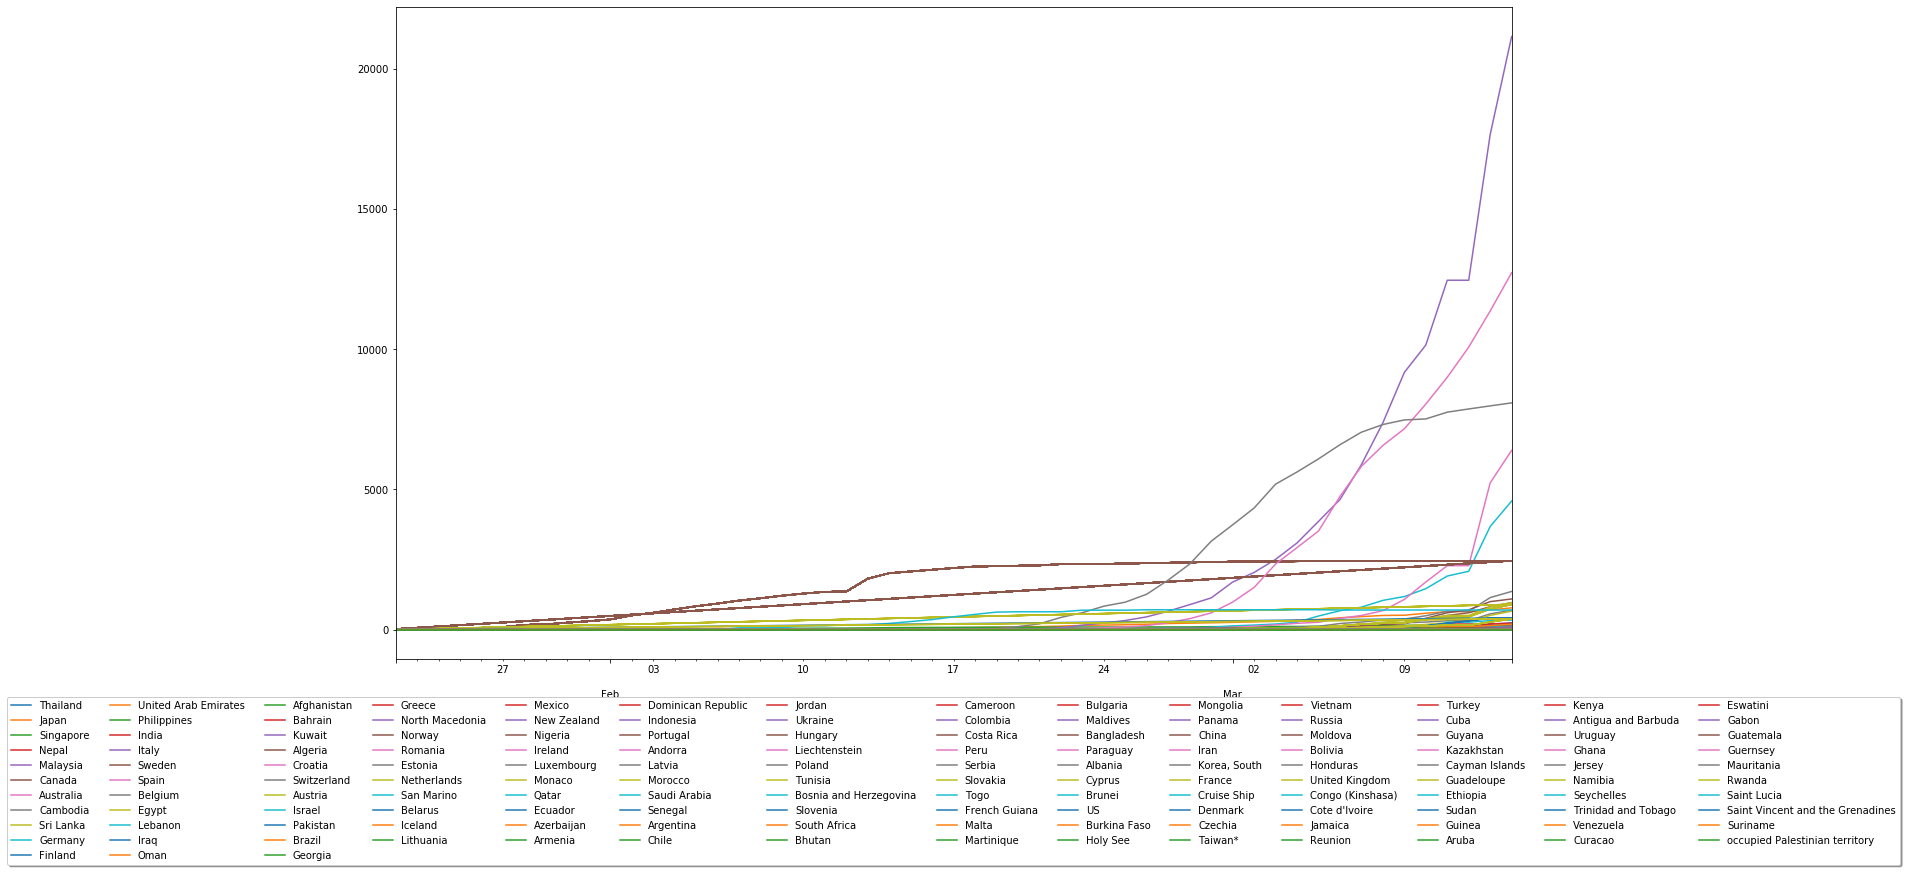

In [22]:
plt.figure(figsize=(20,12))

for c in countries:
    df[df['Country']==c]['value'].plot(label=c)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=14)
plt.show()